In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from io import BytesIO
from PIL import Image as PIL_Image
import numpy as np
from IPython.display import display, Image

def display_img_array(ima, **kwargs):
    if ima.dtype == np.float32 or ima.dtype == np.float64:
        ima = (np.clip(ima, 0., 1.)*255).astype(np.uint8)
    im = PIL_Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Image(bio.getvalue(), format='png', **kwargs))

In [3]:
import pickle
train_X=[]
train_Y=[]
for i in range(1, 6):
    dataset = "cifar-10-batches-py/data_batch_%d"%i
    with open(dataset, 'rb') as f:
        result = pickle.load(f, encoding='latin1')
    train_X.extend(result['data']/255)
    train_Y.extend(result['labels'])
    r2 = result['data'].reshape(-1, 3, 32, 32)[:,:,:,::-1].reshape(-1, 3*32*32)
    train_X.extend(r2/255)
    train_Y.extend(result['labels'])
train_X=np.array(train_X, dtype='float32')
train_Y=np.array(train_Y, dtype='int32')
idx = np.arange(train_X.shape[0])
np.random.shuffle(idx)
train_X = train_X[idx]
train_Y = train_Y[idx]
train_set= (train_X, train_Y)
dataset = "cifar-10-batches-py/test_batch"
with open(dataset, 'rb') as f:
    result = pickle.load(f, encoding='latin1')
test_set = (array(result['data'], dtype='float32')/255, array(result['labels'], dtype='int32'))

In [4]:
print("train_set", train_set[0].shape, train_set[1].shape)
print("test_set", test_set[0].shape, test_set[1].shape)

train_set (100000, 3072) (100000,)
test_set (10000, 3072) (10000,)


9


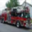

2


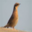

7


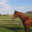

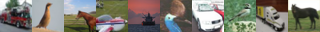

In [5]:
def show(x):
    x = x.reshape(-1, 3, 32, 32)
    w = min(x.shape[0]*100, 800)
    x = x.swapaxes(0, 1).swapaxes(1,2)
    x = x.reshape(3, 32, -1)
    img = np.swapaxes(x, 0, 1)
    img = np.swapaxes(img, 1, 2)
    display_img_array(img, width=w)    
for i in range(3):
    print(train_set[1][i])
    show(train_set[0][i])
show(train_set[0][:10])

In [6]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import DenseLayer, DropoutLayer, ReshapeLayer, InputLayer, FlattenLayer, Upscale2DLayer, LocalResponseNormalization2DLayer
floatX = theano.config.floatX

Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5105)


In [7]:
from lasagne.layers.dnn import MaxPool3DDNNLayer, Conv3DDNNLayer, MaxPool2DDNNLayer, Conv2DDNNLayer

In [ ]:
from lasagne.layers import Deconv2DLayer

In [8]:
from lasagne.layers import batch_norm
from lasagne.objectives import categorical_crossentropy, binary_crossentropy, categorical_accuracy, binary_accuracy

In [9]:
input_var = T.matrix()
_ = InputLayer(shape=(None, 3*32*32), input_var=input_var)
_ = ReshapeLayer(_, ([0], 3, 32, 32))
_ = batch_norm(Conv2DDNNLayer(_, 64, 3, pad='same'))
_ = batch_norm(Conv2DDNNLayer(_, 64, 3, pad='same'))
_ = MaxPool2DDNNLayer(_, 2)
_ = batch_norm(Conv2DDNNLayer(_, 128, 3, pad='same'))
_ = MaxPool2DDNNLayer(_, 2)
_ = batch_norm(Conv2DDNNLayer(_, 256, 3, pad='same'))
_ = batch_norm(Conv2DDNNLayer(_, 64, 3, pad='same'))
_ = FlattenLayer(_)
_ = DenseLayer(_, num_units=1000, nonlinearity=lasagne.nonlinearities.rectify)
l_discriminator = DenseLayer(_, num_units=1, nonlinearity=lasagne.nonlinearities.sigmoid)

NU=32
input_var2 = T.matrix()
_ = InputLayer(shape=(None, NU), input_var=input_var2)
_ = batch_norm(DenseLayer(_, num_units=1000, nonlinearity=lasagne.nonlinearities.rectify))
_ = batch_norm(DenseLayer(_, num_units=64*8*8, nonlinearity=lasagne.nonlinearities.rectify))
_ = ReshapeLayer(_, ([0], 64, 8, 8))
_ = batch_norm(Conv2DDNNLayer(_, 128, 3, pad='same'))
_ = Upscale2DLayer(_, 2)
_ = batch_norm(Conv2DDNNLayer(_, 128, 3, pad='same'))
_ = Upscale2DLayer(_, 2)
_ = batch_norm(Conv2DDNNLayer(_, 128, 3, pad='same'))
_ = batch_norm(Conv2DDNNLayer(_, 128, 3, pad='same'))
_ = batch_norm(Conv2DDNNLayer(_, 3, 3, pad='same', nonlinearity=lasagne.nonlinearities.sigmoid))
l_generator = FlattenLayer(_)

TINY=1e-8
def clip(x):
    return T.clip(x, 1e-8, 1-1e-8)

output_discriminator = lasagne.layers.get_output(l_discriminator)
output_generator_deterministic = lasagne.layers.get_output(l_generator, deterministic=True)
output_generator = lasagne.layers.get_output(l_generator)


output_combined = lasagne.layers.get_output(l_discriminator, inputs=output_generator)

loss_discriminator = -T.log(output_discriminator + TINY).mean() -  T.log(1. - output_combined + TINY).mean()
loss_combined = -T.log(output_combined + TINY).mean()

accuracy_combined = binary_accuracy(output_combined, 
                                     T.zeros_like(output_combined)).mean()
accuracy_discriminator = binary_accuracy(output_discriminator, T.ones_like(output_combined)).mean()
accuracy_discriminator = (accuracy_discriminator + accuracy_combined)/2

params_discriminator = lasagne.layers.get_all_params(l_discriminator, trainable=True) 
params_generator = lasagne.layers.get_all_params(l_generator, trainable=True) 

updates_generator = lasagne.updates.adam(loss_combined, params_generator, 
                                         learning_rate=1e-3,  beta1=0.5)
updates_discriminator = lasagne.updates.adam(loss_discriminator, params_discriminator,
                                             learning_rate=1e-4,  beta1=0.5)

train_generator_fn = theano.function([input_var2], (loss_combined, accuracy_combined), updates=updates_generator)
train_discriminator_fn = theano.function([input_var, input_var2], (loss_discriminator, accuracy_discriminator), updates=updates_discriminator)

generator_fn = theano.function([input_var2], output_generator_deterministic)

j= 0


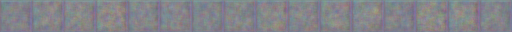

g_err 1.4522490501403809 1.5592337846755981 0.996875
d_err 1.5592337846755981 1.4522490501403809 0.47265625
j= 100


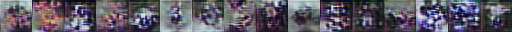

g_err 1.026679515838623 1.3897489309310913 0.84375
d_err 1.3897489309310913 1.026679515838623 0.57421875
j= 200


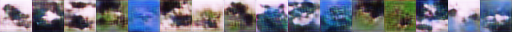

g_err 1.0451728105545044 1.2913110256195068 0.875
d_err 1.2913110256195068 1.0451728105545044 0.64453125
j= 300


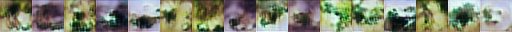

g_err 1.0802985429763794 1.2539780139923096 0.89453125
d_err 1.2539780139923096 1.0802985429763794 0.6484375
j= 400


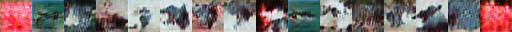

g_err 0.9676003456115723 1.3367092609405518 0.8203125
d_err 1.3367092609405518 0.9676003456115723 0.591796875
j= 500


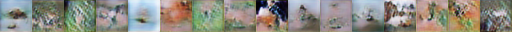

g_err 0.8450103998184204 1.3588635921478271 0.7578125
d_err 1.3588635921478271 0.8450103998184204 0.546875
j= 600


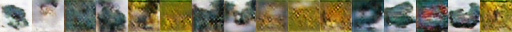

g_err 0.8063737154006958 1.4361984729766846 0.71484375
d_err 1.4361984729766846 0.8063737154006958 0.484375
j= 700


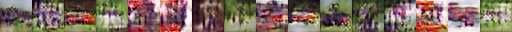

g_err 0.8819794058799744 1.3393568992614746 0.7421875
d_err 1.3393568992614746 0.8819794058799744 0.58984375
j= 800


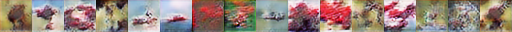

g_err 0.9238666296005249 1.4146257638931274 0.83984375
d_err 1.4146257638931274 0.9238666296005249 0.54296875
j= 900


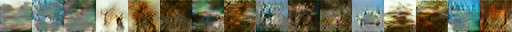

g_err 0.8246511220932007 1.4555989503860474 0.68359375
d_err 1.4555989503860474 0.8246511220932007 0.478515625
j= 1000


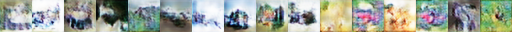

g_err 1.0285840034484863 1.3820416927337646 0.90625
d_err 1.3820416927337646 1.0285840034484863 0.572265625
j= 1100


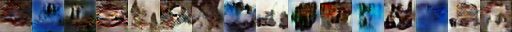

g_err 0.8777211904525757 1.2859971523284912 0.8046875
d_err 1.2859971523284912 0.8777211904525757 0.63671875
j= 1200


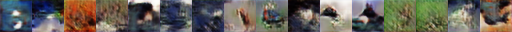

g_err 1.0870723724365234 1.2509315013885498 0.8984375
d_err 1.2509315013885498 1.0870723724365234 0.65625
j= 1300


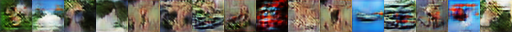

g_err 0.9294095039367676 1.3261330127716064 0.796875
d_err 1.3261330127716064 0.9294095039367676 0.591796875
j= 1400


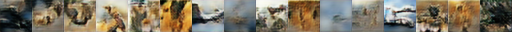

g_err 0.8459415435791016 1.361422061920166 0.6953125
d_err 1.361422061920166 0.8459415435791016 0.603515625
j= 1500


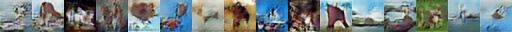

g_err 0.9950090646743774 1.2593305110931396 0.859375
d_err 1.2593305110931396 0.9950090646743774 0.666015625
j= 1600


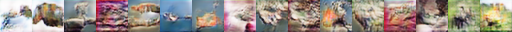

g_err 1.1043795347213745 1.23270583152771 0.88671875
d_err 1.23270583152771 1.1043795347213745 0.66015625
j= 1700


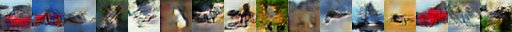

g_err 0.9107197523117065 1.3461143970489502 0.7734375
d_err 1.3461143970489502 0.9107197523117065 0.552734375
j= 1800


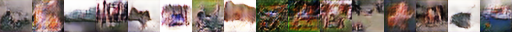

g_err 0.8534678220748901 1.2726831436157227 0.703125
d_err 1.2726831436157227 0.8534678220748901 0.669921875
j= 1900


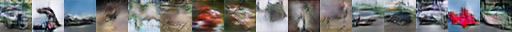

g_err 0.7468181252479553 1.3096582889556885 0.5234375
d_err 1.3096582889556885 0.7468181252479553 0.623046875
j= 2000


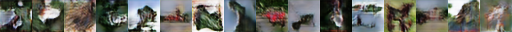

g_err 0.8638518452644348 1.2770862579345703 0.71875
d_err 1.2770862579345703 0.8638518452644348 0.646484375
j= 2100


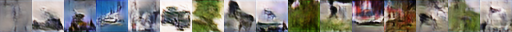

g_err 0.9553698301315308 1.2504634857177734 0.79296875
d_err 1.2504634857177734 0.9553698301315308 0.65625
j= 2200


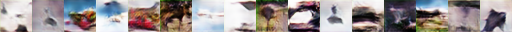

g_err 1.0512343645095825 1.338716983795166 0.87890625
d_err 1.338716983795166 1.0512343645095825 0.607421875
j= 2300


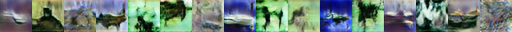

g_err 0.9499301910400391 1.364111065864563 0.7578125
d_err 1.364111065864563 0.9499301910400391 0.5625
j= 2400


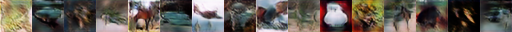

g_err 1.1176825761795044 1.3002060651779175 0.89453125
d_err 1.3002060651779175 1.1176825761795044 0.630859375
j= 2500


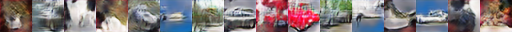

g_err 0.8038419485092163 1.326540231704712 0.625
d_err 1.326540231704712 0.8038419485092163 0.60546875
j= 2600


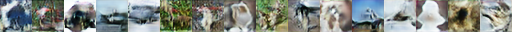

g_err 0.8060351610183716 1.2819781303405762 0.63671875
d_err 1.2819781303405762 0.8060351610183716 0.611328125
j= 2700


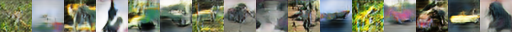

g_err 1.1663199663162231 1.1702524423599243 0.890625
d_err 1.1702524423599243 1.1663199663162231 0.697265625
j= 2800


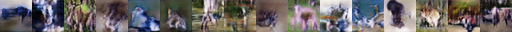

g_err 0.9217201471328735 1.237055778503418 0.70703125
d_err 1.237055778503418 0.9217201471328735 0.697265625
j= 2900


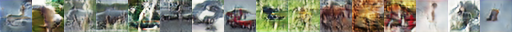

g_err 0.6231955289840698 1.4932652711868286 0.36328125
d_err 1.4932652711868286 0.6231955289840698 0.544921875
j= 3000


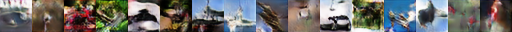

g_err 0.8870053291320801 1.2288485765457153 0.66796875
d_err 1.2288485765457153 0.8870053291320801 0.677734375
j= 3100


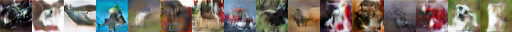

g_err 1.0642991065979004 1.2484402656555176 0.828125
d_err 1.2484402656555176 1.0642991065979004 0.6640625
j= 3200


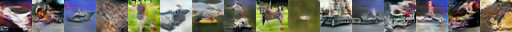

g_err 0.9541135430335999 1.2189817428588867 0.75
d_err 1.2189817428588867 0.9541135430335999 0.650390625
j= 3300


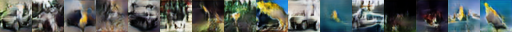

g_err 1.2018206119537354 1.2419607639312744 0.951171875
d_err 1.2419607639312744 1.2018206119537354 0.658203125
j= 3400


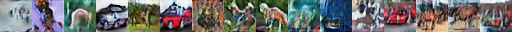

g_err 1.1236307621002197 1.2364336252212524 0.890625
d_err 1.2364336252212524 1.1236307621002197 0.669921875
j= 3500


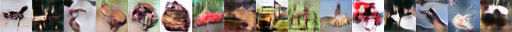

g_err 1.0333027839660645 1.233675241470337 0.8125
d_err 1.233675241470337 1.0333027839660645 0.6640625
j= 3600


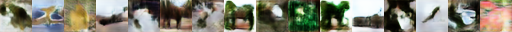

g_err 1.1500580310821533 1.295707106590271 0.967578125
d_err 1.295707106590271 1.1500580310821533 0.6015625
j= 3700


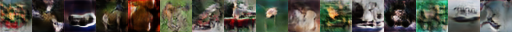

g_err 1.036848783493042 1.27676260471344 0.80859375
d_err 1.27676260471344 1.036848783493042 0.6328125
j= 3800


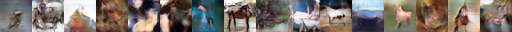

g_err 1.1002286672592163 1.1788320541381836 0.7890625
d_err 1.1788320541381836 1.1002286672592163 0.685546875
j= 3900


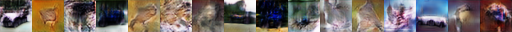

g_err 1.082719087600708 1.1598601341247559 0.898828125
d_err 1.1598601341247559 1.082719087600708 0.669921875
j= 4000


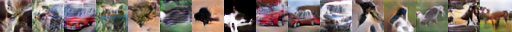

g_err 1.1503314971923828 1.1679461002349854 0.87109375
d_err 1.1679461002349854 1.1503314971923828 0.72265625
j= 4100


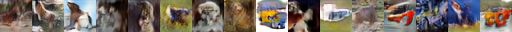

g_err 0.9215004444122314 1.2548893690109253 0.71875
d_err 1.2548893690109253 0.9215004444122314 0.65234375
j= 4200


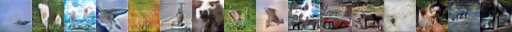

g_err 0.6741815805435181 1.50394868850708 0.41015625
d_err 1.50394868850708 0.6741815805435181 0.505859375
j= 4300


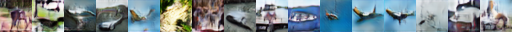

g_err 0.9164631962776184 1.195897102355957 0.68359375
d_err 1.195897102355957 0.9164631962776184 0.6953125
j= 4400


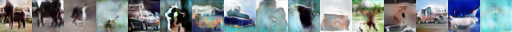

g_err 1.0544333457946777 1.1669764518737793 0.8993359375
d_err 1.1669764518737793 1.0544333457946777 0.701171875
j= 4500


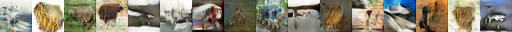

g_err 1.0999433994293213 1.151610255241394 0.92152734375
d_err 1.151610255241394 1.0999433994293213 0.705078125


KeyboardInterrupt: 

In [10]:
import sys
from random import randint
batch_size=256
X=train_set[0] #[train_set[1]==5]
X2=test_set[0]
g_err=d_err=0.1
last_imgs = None
for j in range(1000*1000):
    
    #print("discriminator phase")
    d_acc = -1
    for i in range(1):
        x = X[np.random.randint(0, X.shape[0], size=batch_size)]
        random_input = (np.random.uniform(low=-1, size=(batch_size, NU))).astype('float32')
        d_err, d_acc0 = train_discriminator_fn(x, random_input)
        if d_acc == -1:
            d_acc = d_acc0
        else:
            d_acc = d_acc*0.9+0.1*d_acc0
        if d_err < max(g_err, 0.1):
            break
        if i%100 == -1:
                print(i, "d_err", d_err, g_err, d_acc)   
    
    #print("generator phase")
    g_acc = -1
    for i in range(5):           
        random_input = (np.random.uniform(low=-1, size=(batch_size, NU))).astype('float32')
        g_err, g_acc0 = train_generator_fn(random_input)
        if g_acc == -1:
            g_acc = g_acc0
        else:
            g_acc = g_acc*0.9+0.1*g_acc0
        #g_err = -g_err
        if g_err < max(d_err, 0.1):
            break
        if i%1000 == -1:
            print(i, "g_err", g_err, d_err, g_acc)
    if j%100==0:
        imgs = generator_fn(random_input)
        print("j=", j)
        show(imgs[:16]) 
        print("g_err", g_err, d_err, g_acc)
        print("d_err", d_err, g_err, d_acc)


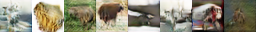

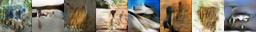

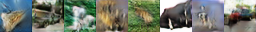

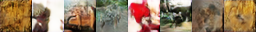

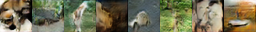

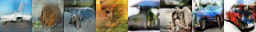

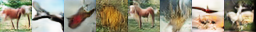

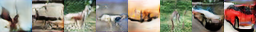

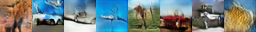

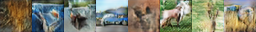

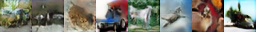

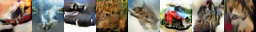

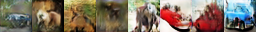

In [11]:
for i in range(0, 100, 8):
    show(imgs[i:i+8])

In [12]:
#np.savez('cifar10_gan_generator.npz', lasagne.layers.get_all_param_values(l_generator))
#np.savez('cifar10_gan_discriminator.npz', lasagne.layers.get_all_param_values(l_discriminator))
